In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import gc
import os 
import fpfs
import fitsio
import galsim
import matplotlib.pylab as plt
from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1 import ImageGrid

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally

2023/01/10 21:01:46 ---  Processing for g1-0000, and shears for four redshift bins are [-0.02 -0.02 -0.02 -0.02].


Making Basic Simulation. ID: 2


15

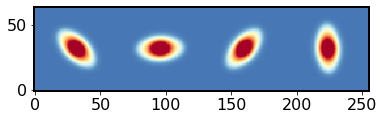

In [2]:
scale = 0.168
outDir='galaxy_basicCenter_psf60'
psfInt = galsim.Moffat(
    beta=3.5, fwhm=0.6, trunc=0.6 * 4.0
).shear(e1=0.02, e2=-0.02)
psfData = psfInt.shift(0.5 * scale, 0.5 * scale).drawImage(nx=64, ny=64, scale=scale).array

gal_data = fpfs.simutil.make_basic_sim(
    outDir,psf_obj=psfInt,gname='g1-0000',
    ind0=2,ny=64,nx=256, scale=scale,
    do_write=False,return_array=True)
plt.close()
plt.imshow(gal_data,aspect='equal',cmap='RdYlBu_r',origin='lower',interpolation='None',\
             norm=simple_norm(gal_data,'asinh',asinh_a=0.1,min_cut=-0.01,max_cut=0.3))
gc.collect()

In [3]:
rcut = 32

# fake detection
indX = np.arange(32, 256, 64)
indY = np.arange(32, 64, 64)
inds = np.meshgrid(indY, indX, indexing="ij")
coords = np.array(
    np.zeros(inds[0].size),
    dtype=[("fpfs_y", "i4"), ("fpfs_x", "i4")],
)
coords["fpfs_y"] = np.ravel(inds[0])
coords["fpfs_x"] = np.ravel(inds[1])
imgList = [
    gal_data[
        cc["fpfs_y"] - rcut : cc["fpfs_y"] + rcut,
        cc["fpfs_x"] - rcut : cc["fpfs_x"] + rcut,
    ]
    for cc in coords
]


In [4]:
fpTask  =   fpfs.image.measure_source(psfData, sigma_arcsec=0.7)
mms =  fpTask.measure(imgList)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000,noirev=False)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp

2023/01/10 21:01:47 ---  Gaussian kernel in configuration space: sigma= 0.7000 arcsec
2023/01/10 21:01:47 ---  measurement covariance will not be calculated


In [5]:
shear

-0.020001147821483375

In [ ]:
scale = 0.168
seeing = 0.6
rcut = 32
psfInt = galsim.Moffat(
    beta=3.5, fwhm=seeing, trunc=seeing * 4.0
).shear(e1=0.02, e2=-0.02)
psf_data = psfInt.shift(0.5 * scale, 0.5 * scale).drawImage(nx=64, ny=64, scale=scale).array

In [ ]:
noise_fname = os.path.join(fpfs.__data_dir__, 'noiPows3.npy')
noi_var = 7e-3
noise_pow = (
    np.load(noise_fname, allow_pickle=True).item()["%s" % rcut]
    * noi_var
    * 100
)

In [ ]:
source_task  =   fpfs.image.measure_source(psfData, noise_ps=noise_pow, sigma_arcsec=0.45)

2023/01/10 21:01:47 ---  Gaussian kernel in configuration space: sigma= 0.4500 arcsec
2023/01/10 21:01:47 ---  measurement error covariance will be calculated


In [ ]:
mms = source_task.measure(imgList)

In [ ]:
mms['fpfs_N00N00'][0]

0.25276049971580505

In [ ]:
cat_fname = os.path.join(fpfs.__data_dir__, 'fpfs-cut32-0000-g1-0000.fits')

In [ ]:
pyfits.getdata(cat_fname)[0]['fpfs_N00N00']

0.25276049971580505

In [ ]:
noise_task = fpfs.image.measure_noise_cov(
    psf_data,
    nnord=4,
    sigma_arcsec=0.45,
)
cov_mat = noise_task.measure(noise_pow)

cov_mat2 = fpfs.catalog.fpfscov_to_imptcov(mms)
for elem1, elem2 in zip(cov_mat.flatten(), cov_mat2.flatten()):
    if elem2 != 0.0:
        np.testing.assert_array_almost_equal(
            elem1,
            elem2,
        )

2023/01/11 00:03:18 ---  Gaussian kernel in configuration space: sigma= 0.4500 arcsec


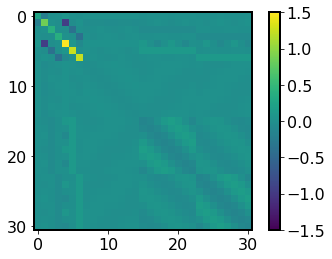

In [27]:
plt.close()
plt.imshow(cov_mat,vmin=-1.5,vmax=1.5)
plt.colorbar()
fitsio.write('modes_cov_mat_paper3_045.fits')

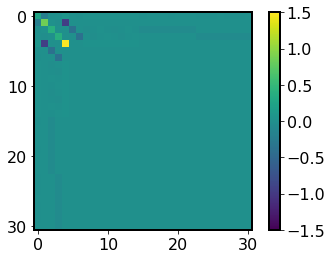

In [ ]:
plt.close()
plt.imshow(cov_mat2,vmin=-1.5,vmax=1.5)
plt.colorbar()